In [41]:
# Dataloading Stuff
from google.colab import drive
from sys import path
import os

# Standard Stuff
!pip3 install numpy sklearn iterative-stratification pandas pyss3
from sklearn.model_selection import train_test_split
import pyss3
from pyss3 import SS3
from pyss3.util import Dataset, Evaluation, span
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import itertools
import numpy as np
import pandas as pd



In [42]:
drive.mount('/content/drive', force_remount=True)
path_root = '/content/drive/My Drive/NLP Lab/SingleLabel/'
path.append(path_root)
data_root = 'data/'

/usr/lib/python3.6/threading.py:868: ResourceWarning: unclosed file <_io.FileIO name=59 mode='wb' closefd=True>
  del self._target, self._args, self._kwargs
/usr/lib/python3.6/threading.py:868: ResourceWarning: unclosed file <_io.FileIO name=61 mode='rb' closefd=True>
  del self._target, self._args, self._kwargs


Mounted at /content/drive


In [43]:

#############  Amazon Alexa Review ############
# df = pd.read_csv(path_root + data_root + "AmazonAlexaReview/amazon_alexa.tsv", sep="\t")
# text = df['verified_reviews'].to_list()
# labels = df['rating'].astype(str).to_list()
#############  Amazon Alexa Review ############


#############  sem eval 2017 ############
df = pd.read_csv(path_root + data_root + "SemEval2017/SemEval2017-task4-dev.subtask-A.english.INPUT.txt", sep="\t", header=None)
df = df[[1,2]]

labels = df[1].to_list()
text = df[2].to_list()
#############  sem eval 2017 ############

############## beer review ###############
# with open(path_root + data_root + 'BeerReview/test.txt', 'r') as text_file:
#   text = text_file.read().split('\n')

# with open(path_root + data_root + 'BeerReview/test_label.txt', 'r') as label_file:
#   labels = label_file.read().split('\n')
############## beer review ###############

X_train, X_val, y_train, y_val = train_test_split(text, labels, test_size=0.2)

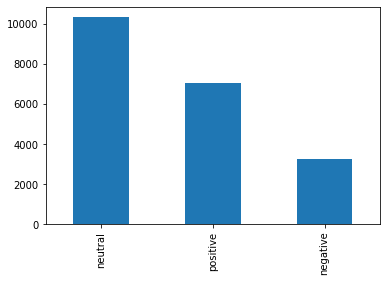

In [44]:
pd.Series([yy for yy in labels]).value_counts().plot(kind ='bar')

In [45]:
def binarize_label(y_train):
  data_by_class = {}
  for label in set(y_train):
    data_by_class[label] = [label if x == label else 'other' for x in y_train]
  return data_by_class

In [46]:
def train_clfs(X_train, y_train):
  clf_by_class = {}
  if isinstance(y_train, dict):
    for key, value in y_train.items():
      clf = SS3(name=key)
      clf.train(X_train, value,n_grams=5)
      clf_by_class[key] = clf
  else:
    print("data per class not found")
  
  return clf_by_class


In [47]:
def change_parameter(s,l,p,a, clfs):
  for key, value in clfs.items():
    value.set_hyperparameters(s,l,p,a)

In [48]:
def classify_clfs(data, clfs):
  predict = {}
  if isinstance(clfs, dict):
    for key, value in clfs.items():
      predict[key] = value.predict_proba(data) + [value.get_category_index(key)] 
  else:
    print("clf per class not found")

  return predict


In [49]:
def predicted(predicted_clfs, iterations):
  predicted = []
  for i in range(iterations):
    last_value = 0
    label = ''
    for key, value in predicted_clfs.items():
      score = value[i][value[-1]]
      if score > last_value:
        last_value = score
        label = key
    # print("last_value: ", last_value, " and Label: ", label)
    predicted.append(label)
  return predicted

# **DEFAULT COMPARISON**

In [50]:
pyss3.set_verbosity(1)
binarized_data = binarize_label(y_train)
clfs = train_clfs(X_train, binarized_data)

Training on 'positive': 100%|██████████| 2/2 [00:06<00:00,  3.01s/it]


In [51]:
predicted_clfs = classify_clfs(X_val,clfs)
y_pred = predicted(predicted_clfs, len(X_val))

Classification: 100%|██████████| 4127/4127 [00:02<00:00, 1775.55it/s]


Macro F1 score :  0.538088205894752
Micro F1 score:  0.546159437848316
 ------- 


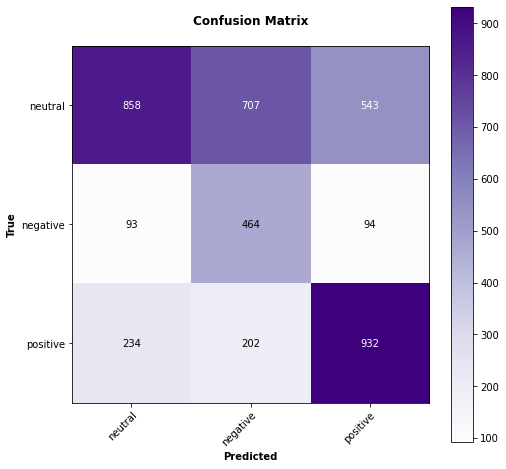

In [52]:
print("Macro F1 score : " , f1_score(y_val, y_pred, average='macro'))
print("Micro F1 score: " , f1_score(y_val, y_pred, average='micro'))
print(" ------- ")
categories = list(set(labels)) 
# ConfusionMatrixDisplay(confusion_matrix(y_val, y_pred, labels=categories),display_labels=categories).plot(values_format='.1f')
Evaluation.__plot_confusion_matrices__([confusion_matrix(y_val, y_pred, labels=categories)], categories)

Training on 'positive': 100%|██████████| 3/3 [00:05<00:00,  1.93s/it]



              precision    recall  f1-score   support

    negative       0.34      0.75      0.47       687
     neutral       0.65      0.39      0.49      2006
    positive       0.60      0.58      0.59      1434

    accuracy                           0.52      4127
   macro avg       0.53      0.57      0.51      4127
weighted avg       0.58      0.52      0.52      4127


 Accuracy: 0.517



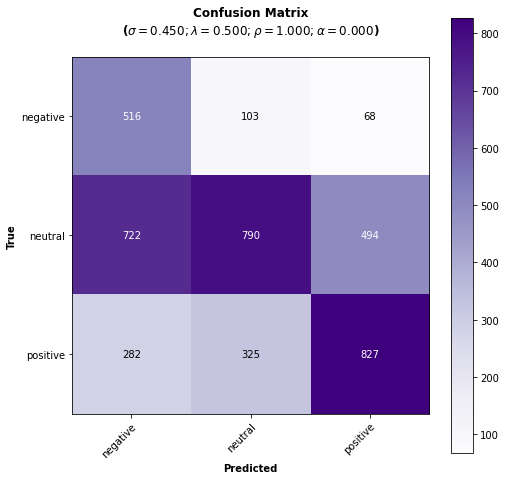

0.5145263486650616

In [55]:
clf = SS3()
clf.train(X_train, y_train,n_grams=5)
Evaluation.test(clf, X_val, y_val, metric="f1-score")

# **GRID SEARCH**

In [ ]:
s=span(0, 1, 11)  # [0.2 , 0.32, 0.44, 0.56, 0.68, 0.8]
l=span(0, 1, 6)   # [0.1 , 0.48, 0.86, 1.24, 1.62, 2]
p=span(0, 1, 6)   # [1.75, 1.95, 2.15, 2.35, 2.55, 2.75]
a=span(0, 5, 6)
slpa = list(itertools.product(s,l,p,a))
iterations = len(slpa)
divider = 50

In [ ]:
pyss3.set_verbosity(0)
current_iteration = 0
last_metric_value = 0
last_metric_value_default = 0
best_y_pred = []
best_y_pred_default = []
for s,l,p,a in slpa:
  current_iteration += 1
  print('\r',current_iteration, end='')

  change_parameter(s,l,p,a,clfs)
  clf.set_hyperparameters(s,l,p,a)
  predicted_clfs = classify_clfs(X_val,clfs)
  y_pred = predicted(predicted_clfs, len(X_val))
  metric_value = f1_score(y_val, y_pred, average='macro')
  if(metric_value > last_metric_value):
    last_metric_value = metric_value
    best_y_pred = y_pred
    best = (s,l,p,a)  
  
  clf.set_hyperparameters(s,l,p,a)
  y_pred_default = clf.predict(X_val)
  metric_value_default = f1_score(y_val, y_pred_default, average='macro')
  if(metric_value_default > last_metric_value_default):
    last_metric_value_default = metric_value_default
    best_y_pred_default = y_pred_default
    best_default = (s,l,p,a)   

  if(current_iteration%divider == 0):
    print(' -> best value so far: ', last_metric_value, ' -> best values: s={}, l={}, p={}, a={}'.format(best[0], best[1], best[2], best[3]), "iterations: ", current_iteration, "/", iterations)
    print(' -> best value so far: ', last_metric_value_default, ' -> best values: s={}, l={}, p={}, a={}'.format(best_default[0], best_default[1], best_default[2], best_default[3]), "iterations: ", current_iteration, "/", iterations)
    print('------------------------')

 50 -> best value so far:  0.21988274072323633  -> best values: s=0.0, l=0.2, p=0.2, a=0.0 iterations:  50 / 2376
 -> best value so far:  0.38341432797523706  -> best values: s=0.0, l=0.2, p=0.2, a=0.0 iterations:  50 / 2376
------------------------
 100 -> best value so far:  0.21988274072323633  -> best values: s=0.0, l=0.2, p=0.2, a=0.0 iterations:  100 / 2376
 -> best value so far:  0.38341432797523706  -> best values: s=0.0, l=0.2, p=0.2, a=0.0 iterations:  100 / 2376
------------------------
 150 -> best value so far:  0.21988274072323633  -> best values: s=0.0, l=0.2, p=0.2, a=0.0 iterations:  150 / 2376
 -> best value so far:  0.38341432797523706  -> best values: s=0.0, l=0.2, p=0.2, a=0.0 iterations:  150 / 2376
------------------------
 200 -> best value so far:  0.21988274072323633  -> best values: s=0.0, l=0.2, p=0.2, a=0.0 iterations:  200 / 2376
 -> best value so far:  0.38341432797523706  -> best values: s=0.0, l=0.2, p=0.2, a=0.0 iterations:  200 / 2376
----------------

KeyboardInterrupt: ignored

In [ ]:
print("F1 score micro: " , f1_score(y_val, best_y_pred, average='micro'))
print("F1 score macro: " , f1_score(y_val, best_y_pred, average='macro'))
print(" ------- ")
categories = list(set(labels)) 
ConfusionMatrixDisplay(confusion_matrix(y_val, best_y_pred, labels=categories),display_labels=categories).plot(values_format='.1f')

In [ ]:
clf.set_hyperparameters(s=best_default[0], l=best_default[1], p=best_default[2], a=best_default[3])
Evaluation.test(clf, X_val, y_val)